# <font color='green'>Homework 5</font>

<div class="alert alert-block alert-warning">
<b>
University of Tehran<br>
Fall 2022<br>
Course: Interactive Learning<br>
</div>


***

<div class="alert alert-block alert-success">
<b>Author:</b><br>
Name: Taban Soleymani <br />
Student Number: 
</div>

***

# <span style="color:purple">Importing Required Packages and Classes</span>

In [ ]:
!pip install gym
!pip install highway-env
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import highway_env

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 KB 15.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827650 sha256=36c198d69bdecdd62b42d300b9f589d0fa07c2f5525f39abe751095b9e1ad751
  Stored in directory: /root/.cache/pip/wheels/17/79/65/7afedc162d858b02708a3b8f7a6dd5b1000dcd5b0f894f7cc1
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
Looki

# <span style="color:purple">Environment</span>

In [ ]:
env = gym.make('highway-fast-v0').unwrapped

In [ ]:
class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [ ]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))


In [ ]:
def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0)

In [ ]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


In [ ]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())



In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
def model(repeat, num_episodes):
    all_reward = np.zeros(shape=(repeat, num_episodes))
    for rep in range(repeat):
        total_reward = 0
      
      for i_episode in range(num_episodes):
          
        env.reset()
        rewards = []
        last_screen = get_screen()
        current_screen = get_screen()
        state = current_screen - last_screen    
          for t in count():
             
            action = select_action(state)
            _, reward, done, _, _ = env.step(action.item())
            total_reward += reward
            rewards.append(reward)
            reward = torch.tensor([reward], device=device)
            last_screen = current_screen
            current_screen = get_screen()
            if not done:
                  next_state = current_screen - last_screen
            else:
                  next_state = None

              
            memory.push(state, action, next_state, reward)

            state = next_state

            optimize_model()
            if done:
                episode_durations.append(t + 1)
                plot_durations()
                break
            all_reward[rep][i_episode] = np.sum(rewards)
            if i_episode % 100 == 0:
                print(f"Mean episode {i_episode}/1000 reward is:{total_reward / 100:.2f}")
                total_reward = 0
          
            if i_episode % TARGET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())
    return all_reward

In [ ]:
def run_episode(env, render = True):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    total_reward = 0
    frames = []
    for t in count():
        if render:
            frames.append(env.render(mode="rgb_array"))
        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())
        total_reward += reward

        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        state = next_state

        if done:
            break
    
    return total_reward, frames

In [ ]:
def save_frames_as_gif(frames, path='render/', filename='merge-v0.gif'):

    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('on')

    def animate(i):
        patch.set_data(frames[i])
    writer = animation.PillowWriter(fps=480,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=200)
    anim.save(path + filename, writer=writer)

# <span style="color:purple">Part3 : Ordinary Learning </span>

<Figure size 432x288 with 0 Axes>

Average score of the policy:  18.99612673366943


<Figure size 432x288 with 0 Axes>

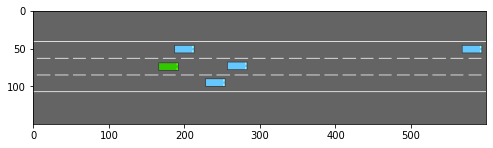

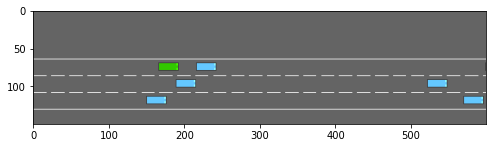

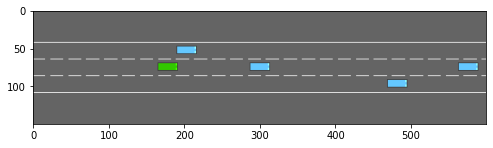

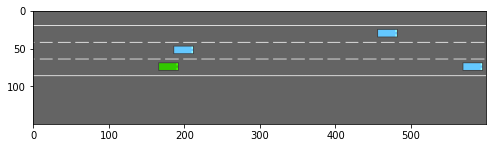

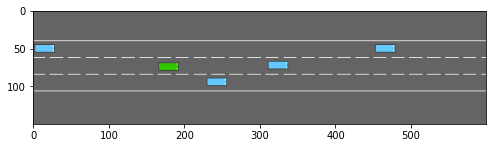

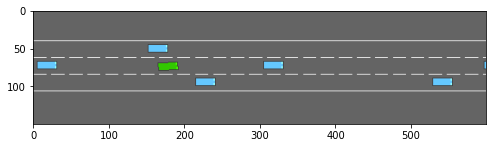

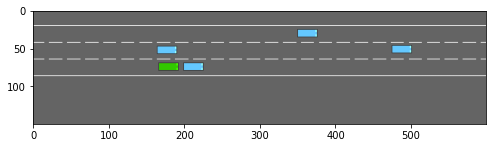

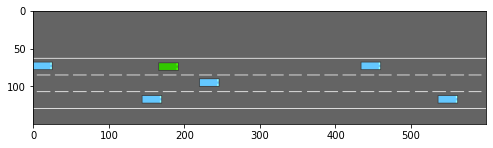

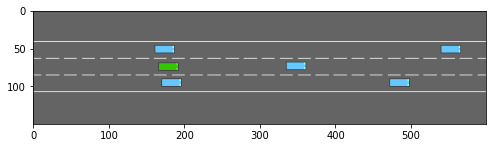

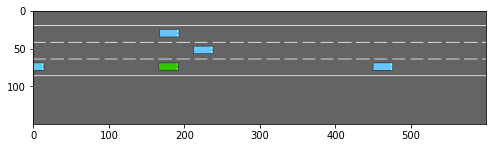

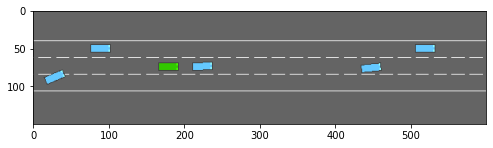

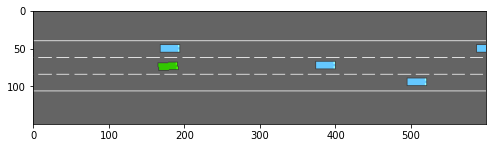

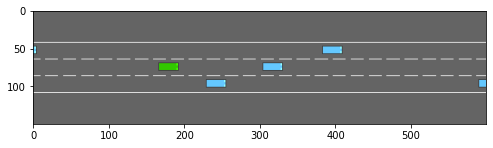

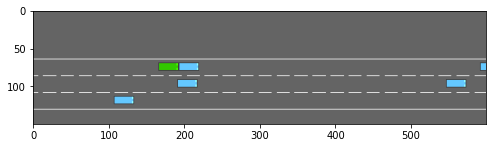

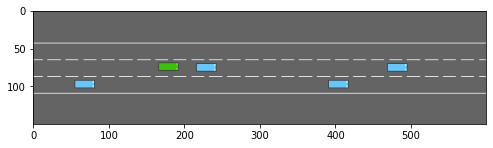

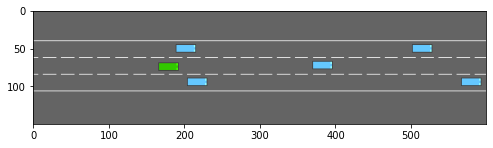

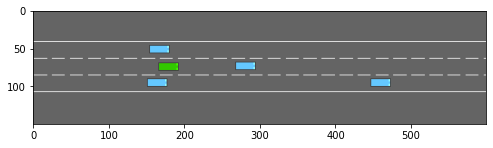

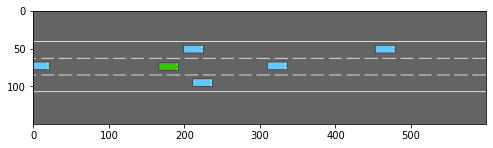

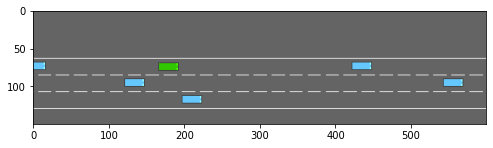

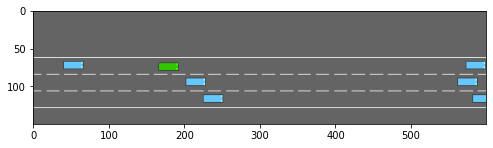

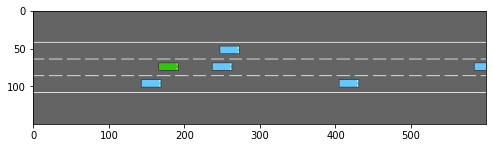

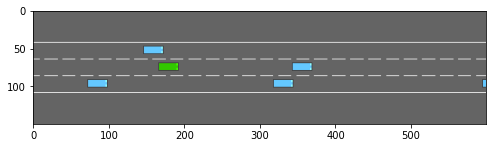

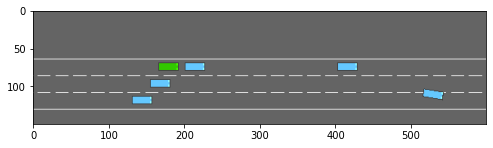

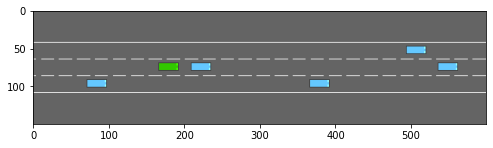

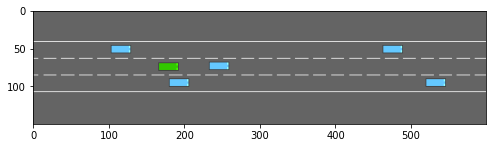

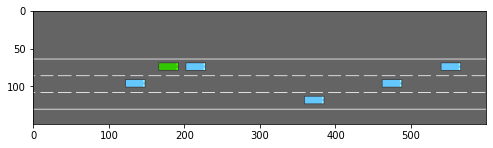

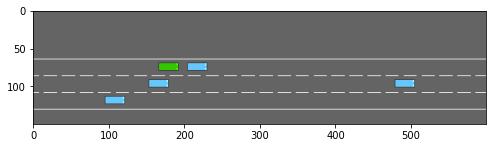

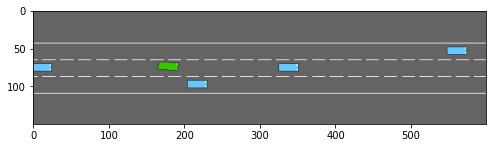

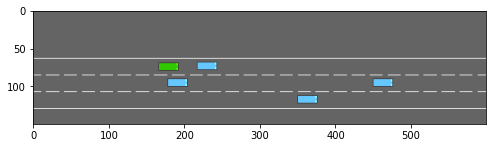

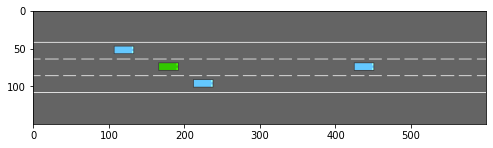

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

resize = T.Compose([T.ToPILImage(),
                    T.Resize(100, interpolation=T.InterpolationMode.BICUBIC),
                    T.ToTensor()])


env.reset()
plt.imshow(env.render(mode="rgb_array"))
plt.show()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
display.display(plt.gcf())  
plt.title('Example Extracted Screen')
plt.show()


learning_rate = 1e-3
BATCH_SIZE = 32
GAMMA = 0.9
EPS_START = 1
EPS_END = 1e-3
EPS_DECAY = 200
TARGET_UPDATE = 50


init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = Adam(policy_net.parameters(),lr = learning_rate)
memory = ReplayMemory(10000)

steps_done = 0

episode_durations = []


policy_net.load_state_dict(torch.load("model-merge.pt"))
all_rews = model(5, 1000)
torch.save(policy_net.state_dict(), "model-tl-hwf.pt")

steps_done = 1000000000000
policy_net.load_state_dict(torch.load("model-tl-hwf.pt"))
rewards = []
for i in range(30):
    reward, frame = run_episode(env)
    rewards.append(reward)
    save_frames_as_gif(frame, filename=f'hwftl{i}.gif')
print("Average score of the policy: ", np.mean(rewards))
env.close()

In [ ]:
from scipy.stats import t
# print(all_rews.shape)
means_rewards = all_rews.mean(axis=0)
df = pd.DataFrame(means_rewards)
rolling = df.rolling(50).mean()
m=rolling.mean()
rolling.fillna(value=m, inplace=True)
rolling = rolling.to_numpy()
rolling = np.squeeze(rolling)
alpha=0.001
confidence_interval = np.abs(t.ppf(alpha/2,len(rolling)-1)) * np.std(rolling) / np.sqrt(len(rolling))

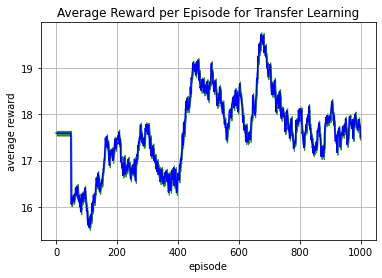

In [ ]:
plt.plot(rolling,c='b')
plt.fill_between(np.arange(1,1001,1), (rolling - confidence_interval),
                 (rolling + confidence_interval), color='g', alpha=0.8)
plt.xlabel("episode")
plt.ylabel("average reward")
plt.title("Average Reward per Episode for Transfer Learning")
plt.grid()